In [29]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as dist
import torchvision.utils

import time
import utils

latent_dims = 9
num_epochs = 100
batch_size = 128
capacity = 64
learning_rate = 1e-3
variational_beta = 1
use_gpu = True

img_width = 28 
img_height = 28
img_size = img_width*img_height

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [21]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST, MNIST

img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = FashionMNIST(root='~/data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = FashionMNIST(root='~/data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Model

In [22]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc_1 = nn.Linear(in_features=img_size, out_features=50)
        self.fc_mu = nn.Linear(in_features=50, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=50, out_features=latent_dims) # why are we optimizing for log variance? Because it's more stable?
        
    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten image matrix to image vector
        x = F.relu(self.fc_1(x))
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        
        return x_mu, x_logvar
        
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc_1 = nn.Linear(in_features=latent_dims, out_features=50)
        self.fc_2 = nn.Linear(in_features=50, out_features=img_size)
        
    def forward(self, x):
        x = F.relu(self.fc_1(x))
        x = torch.sigmoid(self.fc_2(x))
        x = x.view(x.size(0), img_width, img_height) # unflatten
        return x   
    

class MeanfieldAutoencoder(nn.Module):
    def __init__(self):
        super(MeanfieldAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.loss_mse = torch.nn.MSELoss(reduction='none')
        
    def forward(self, x):
        mu_latent, logvar_latent = self.encoder(x)
        
        std = logvar_latent.mul(0.5).exp_()
        latent = dist.normal.Normal(mu_latent, std).rsample()
        
        x_reconstruction = self.decoder(latent)
        
        return x_reconstruction, mu_latent, logvar_latent
    
        
    def loss(self, pred, target):
        return torch.mean(torch.sum(self.loss_mse(pred, target), dim=-1))

mfae = MeanfieldAutoencoder()
mfae.to(device)

num_params = sum(p.numel() for p in mfae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 80652


# Training

Training...
Epoch [1 / 100] average reconstruction error: 1.307826
Epoch [6 / 100] average reconstruction error: 0.523844
Epoch [11 / 100] average reconstruction error: 0.487785
Epoch [16 / 100] average reconstruction error: 0.471869
Epoch [21 / 100] average reconstruction error: 0.462859
Epoch [26 / 100] average reconstruction error: 0.456337
Epoch [31 / 100] average reconstruction error: 0.451104
Epoch [36 / 100] average reconstruction error: 0.447004
Epoch [41 / 100] average reconstruction error: 0.443612
Epoch [46 / 100] average reconstruction error: 0.441032
Epoch [51 / 100] average reconstruction error: 0.438609
Epoch [56 / 100] average reconstruction error: 0.436955
Epoch [61 / 100] average reconstruction error: 0.435233
Epoch [66 / 100] average reconstruction error: 0.433583
Epoch [71 / 100] average reconstruction error: 0.432163
Epoch [76 / 100] average reconstruction error: 0.430736
Epoch [81 / 100] average reconstruction error: 0.429577
Epoch [86 / 100] average reconstructio

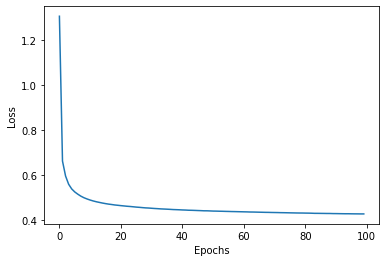

In [23]:
optimizer = torch.optim.Adam(params=mfae.parameters(), lr=learning_rate, weight_decay=1e-5)
mfae.train()
train_loss_avg = []

print("Training...")
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    
    for image_batch, _ in train_dataloader:
        image_batch = image_batch.squeeze().to(device)
        
        image_batch_reconstruction, mu_latent, logvar_latent = mfae(image_batch)
        loss = mfae.loss(image_batch_reconstruction, image_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_avg[-1] += loss.item()
        num_batches+=1
    train_loss_avg[-1] /= num_batches
    if (epoch % 5 == 0):
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))
        
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Evaluation

In [27]:
# set to evaluation mode
mfae.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:
    
    with torch.no_grad():
    
        image_batch = image_batch.squeeze().to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = mfae(image_batch)

        # reconstruction error
        loss = mfae.loss(image_batch_recon, image_batch)

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 0.430314


# Visualize

In [31]:
def gallery(images, ncols = 10):
    nindex, height, width = images.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    result = (images.reshape(nrows, ncols, height, width)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols))
    return result

def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):
    with torch.no_grad():
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        
        np_imagegrid = gallery( torchvision.utils.make_grid(images[1:51], 10, 5).numpy())
        plt.imshow(np_imagegrid, cmap="gray")
        plt.show()
        


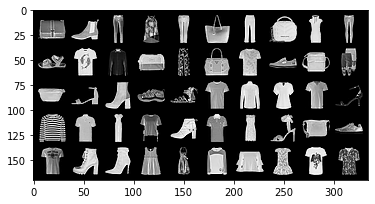

Mean field VAE reconstruction:


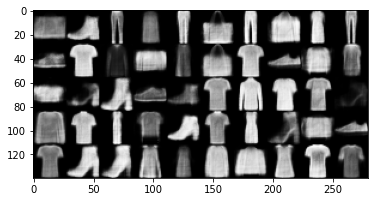

In [33]:
plt.ion()

images, labels = iter(test_dataloader).next()

mfae.eval()

# First visualise the original images
imgs = torchvision.utils.make_grid(images[1:51],10,5)
utils.show_image(imgs)
plt.show()


# Reconstruct and visualise the images using the vae
print('Mean field VAE reconstruction:')
visualise_output(images, mfae)
